# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops

by match1

<i>Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.</i>

The dataset can be found in the data folder with the file name `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  

This project contains multi-class classification models to predict the type of `"crop"` and identify the single most importance feature for predictive performance.

### Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score

### Load and Explore Data

In [4]:
# Load the dataset
crops_df = pd.read_csv("../data/soil_measures.csv")

crops_df.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [3]:
crops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2200 non-null   int64  
 1   P       2200 non-null   int64  
 2   K       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB


In [7]:
crops_df.iloc[:,0:3].var()

N    1362.889537
P    1088.068460
K    2565.212869
dtype: float64

In [5]:
crops_df['crop'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

### Data Visualization

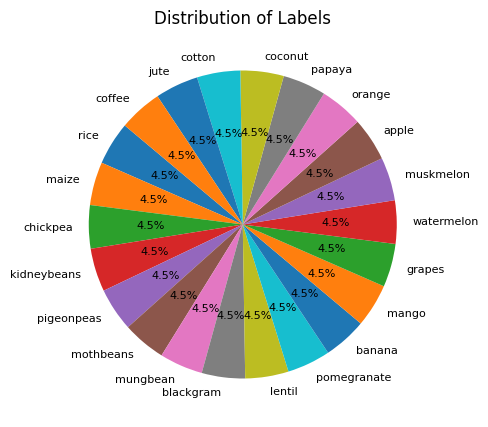

In [6]:
crop_types_count = crops_df['crop'].value_counts()

#  Plot pie chart to show proportions of crop types in the dataset
plt.figure(figsize=(5, 5))
plt.pie(crop_types_count, labels=crop_types_count.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 8})
plt.title('Distribution of Labels')
plt.show()

In [7]:
# Compute for correlation to identify highly correlated features, which might indicate redundancy
corr_matrix = crops_df[['N','P','K','ph']].corr()
corr_matrix

,N,P,K,ph
N,1.000000,-0.231460,-0.140512,0.096683
P,-0.231460,1.000000,0.736232,-0.138019
K,-0.140512,0.736232,1.000000,-0.169503
ph,0.096683,-0.138019,-0.169503,1.000000


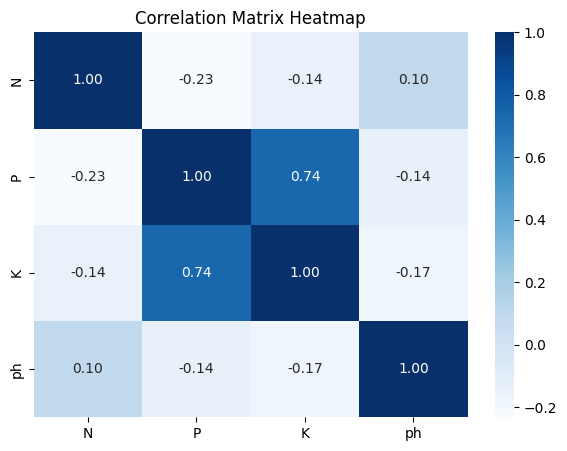

In [8]:
# Plot the heatmap for correlation matrix
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

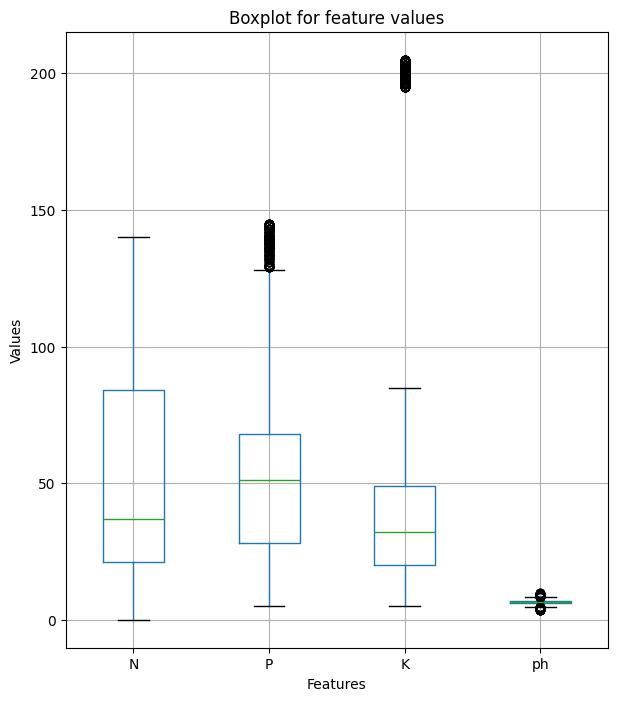

In [9]:
crops_df.boxplot(figsize=(7, 8))
plt.title('Boxplot for feature values')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

- Potassium (K) show higher variability with numerous outliers above their upper whiskers.
- Phosphorous (P) exhibits fewer outliers but still shows values exceeding the upper whisker.

### Data Preprocessing

#### Check for missing values

In [10]:
crops_df.isna().sum()

N       0
P       0
K       0
ph      0
crop    0
dtype: int64

#### Encode `'crop'` column

In [11]:
label_encoder = LabelEncoder()
crops_df['crop'] = label_encoder.fit_transform(crops_df['crop'])

# Code to see which crops correspond to which encoded number
#   crops_df['crop_enc'] = label_encoder.fit_transform(crops_df['crop'])
#   mapping_df = crops_df[['crop', 'crop_enc']].drop_duplicates().sort_values(by='crop_enc')
#   mapping_df

#### Split the data

In [12]:
X = crops_df.drop('crop', axis=1)
y = crops_df['crop']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Log Transformation (for features that have many outliers)

In [13]:
# Apply log transformation to 'P' and 'K' columns since they exhibit skewed distributions
log_columns = ['P', 'K']
for column in log_columns:
    X_train[column] = np.log(X[column] + 1)
    X_test[column] = np.log(X[column] + 1)

#### Feature Scaling

In [14]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Defining the models

In [15]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=500),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

### Training and Testing the models (baseline performance)
**Chosen Metric:**
- `Accuracy` - measures the proportion of correctly predicted instances out of the total instances. It provides a straightforward measure of overall model performance and is particularly suitable for balanced datasets where each class is equally important.

In [16]:
model_names = []
accuracies = []

# Train, predict and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    model_names.append(name)
    accuracies.append(accuracy_score(y_test, y_pred))

# Store the results in df
baseline_perf = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
})


#### Plotting baseline model performance

[0.6795454545454546, 0.7545454545454545, 0.7818181818181819]


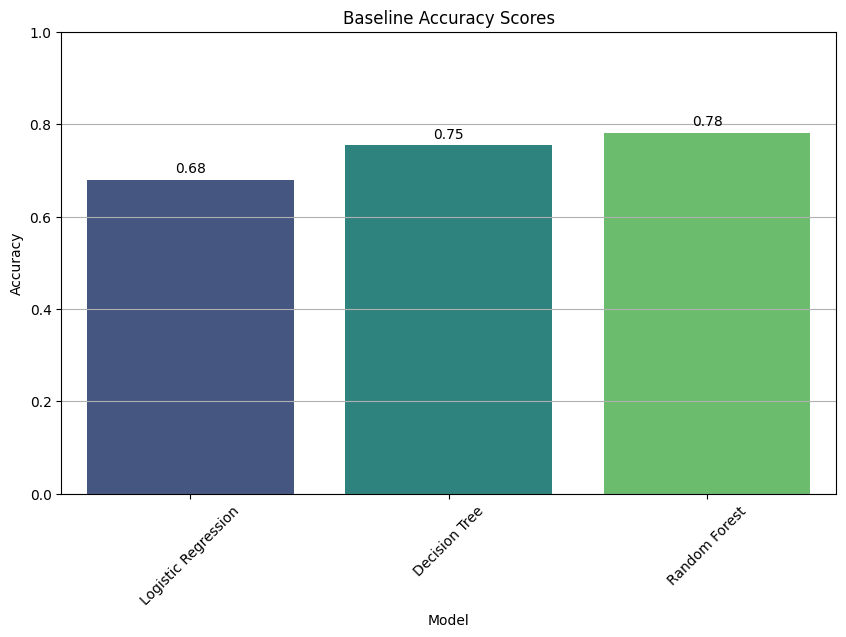

In [17]:
# Plot Baseline Accuracy Scores
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='Model', y='Accuracy', data=baseline_perf, palette='viridis', hue='Model', dodge=False, legend=False)
plt.title('Baseline Accuracy Scores')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')

# Add values on top of bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding=3)

print(accuracies)


### Hyperparameter Tuning
#### Defining the models and their respective parameters for grid search

In [18]:
# Defining the models and their respective parameters for grid search
models = {
    'Logistic Regression': {
        'model': LogisticRegression(solver='lbfgs', max_iter=200),
        'params': {
            'clf__C': [0.1, 1.0, 10.0],  # Regularization parameter
            'clf__penalty': ['l2']  # Regularization type
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'clf__criterion': ['gini', 'entropy'],  # Split criterion
            'clf__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
            'clf__min_samples_split': [2, 5, 10]  # Minimum number of samples required to split
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'clf__n_estimators': [50, 100, 200],  # Number of trees
            'clf__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
            'clf__min_samples_split': [2, 5, 10]  # Minimum number of samples required to split
        }
    }
}

#### Perform GridSearch for Hyperparameter Tuning

In [19]:
best_models = []

# Iterate through each model and perform Grid Search
for model_name, model_params in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model_params['model'])
    ])
    
    grid_search = GridSearchCV(pipeline, model_params['params'], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_model = grid_search.best_estimator_
    
    
    best_models.append({
        'Model': model_name,
        'Best Parameters': best_params,
        'Best CV Accuracy': best_score,
    })
    
    print(f"Best parameters for {model_name}: {best_params}")
    print(f"Cross-validation Accuracy: {best_score:.4f}")
    print()

Best parameters for Logistic Regression: {'clf__C': 10.0, 'clf__penalty': 'l2'}
Cross-validation Accuracy: 0.6830

Best parameters for Decision Tree: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 5}
Cross-validation Accuracy: 0.7949

Best parameters for Random Forest: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Cross-validation Accuracy: 0.8068



#### Plotting improved model performance

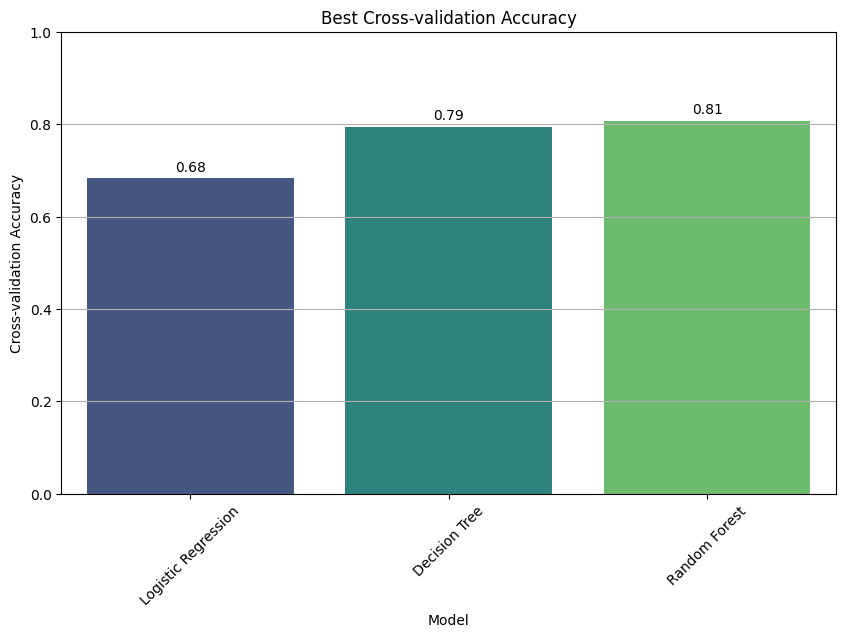

In [20]:
# Convert to df
best_models_df = pd.DataFrame(best_models)

# Plot improved model performance
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='Model', y='Best CV Accuracy', data=best_models_df, palette='viridis', hue='Model', dodge=False, legend=False)
plt.title('Best Cross-validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Cross-validation Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add values on top of bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', padding=3)

plt.show()

### Identifying the single most importance feature for predictive performance

#### Feature importance for Logistic Regression

Feature Performance (normalized):
{'N': {'Feature': 'N', 'Importance': np.float64(0.19510440711668917)}, 'P': {'Feature': 'P', 'Importance': np.float64(0.8622745401661355)}, 'K': {'Feature': 'K', 'Importance': np.float64(1.0)}, 'ph': {'Feature': 'ph', 'Importance': np.float64(0.0)}}


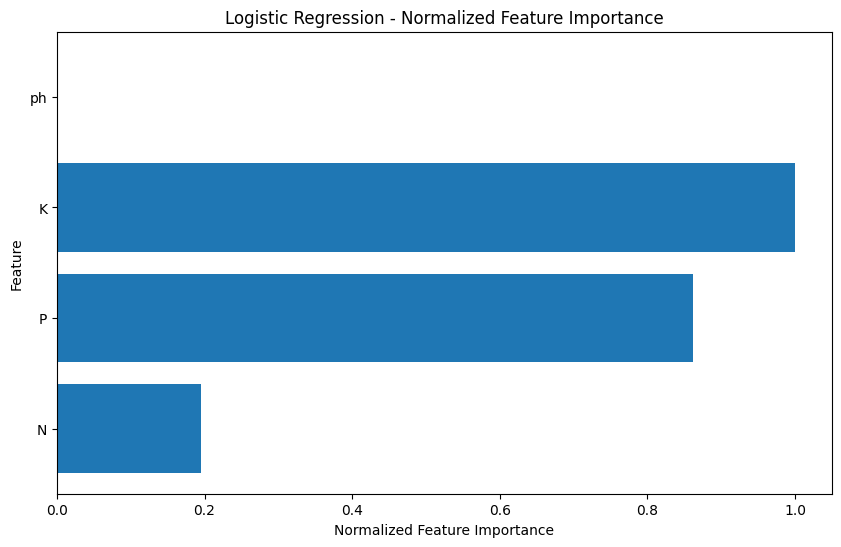

Feature Performance using balanced_accuracy_score:
Logistic Regression: Most Important Feature - K, Importance - 1.0000


In [21]:
# Extracting the best parameters for Logistic Regression from best_models after tuning the model
log_reg_best_params = best_models_df.loc[best_models_df['Model'] == 'Logistic Regression', 'Best Parameters'].values[0]

# Define Logistic Regression best parameters
log_reg_params = {
    'C': log_reg_best_params['clf__C'],
    'penalty': log_reg_best_params['clf__penalty'],
    'solver': 'lbfgs',
    'max_iter': 500,
    'random_state': 42
}

features = ["N", "P", "K", "ph"]

feature_performance = {}

# Scale the data and keep it as a DataFrame
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Loop through each feature
for feature in features:
    # Train logistic regression model using best parameters
    log_reg = LogisticRegression(**log_reg_params)
    
    # Ensure X_train_scaled[feature] is a 2D array
    X_train_feature = X_train_scaled[[feature]]
    X_test_feature = X_test_scaled[[feature]]
    
    log_reg.fit(X_train_feature, y_train)
    
    # Predict using the test set
    y_pred = log_reg.predict(X_test_feature)
    
    # Evaluate the performance using balanced_accuracy_score
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    
    # Identify the most important feature based on coefficient magnitude
    most_important_feature_index = abs(log_reg.coef_[0]).argmax()
    most_important_feature_name = feature  # Since we are already looping through features
    importance = abs(log_reg.coef_[0][most_important_feature_index])
    
    # Store the most important feature and its importance in feature_performance
    feature_performance[feature] = {
        'Feature': most_important_feature_name,
        'Importance': importance
    }

# Normalize the importance values to a range between 0 and 1
importance_values = [feat['Importance'] for feat in feature_performance.values()]
min_importance = min(importance_values)
max_importance = max(importance_values)

for feature in feature_performance:
    feature_performance[feature]['Importance'] = (feature_performance[feature]['Importance'] - min_importance) / (max_importance - min_importance)

# Print feature performance dictionary
print("Feature Performance (normalized):")
print(feature_performance)

# Plotting the normalized feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_performance)), [feat['Importance'] for feat in feature_performance.values()], align='center')
plt.yticks(range(len(feature_performance)), feature_performance.keys())
plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature')
plt.title('Logistic Regression - Normalized Feature Importance')
plt.show()

# Find the feature with the largest normalized importance value
log_reg_best_feature = max(feature_performance, key=lambda k: feature_performance[k]['Importance'])
log_reg_best_importance = feature_performance[log_reg_best_feature]['Importance']

print("Feature Performance using balanced_accuracy_score:")
print("Logistic Regression: " + f"Most Important Feature - {log_reg_best_feature}, Importance - {log_reg_best_importance:.4f}")

#### Feature importance for Random Forest Classifier and Decision Tree Classifier

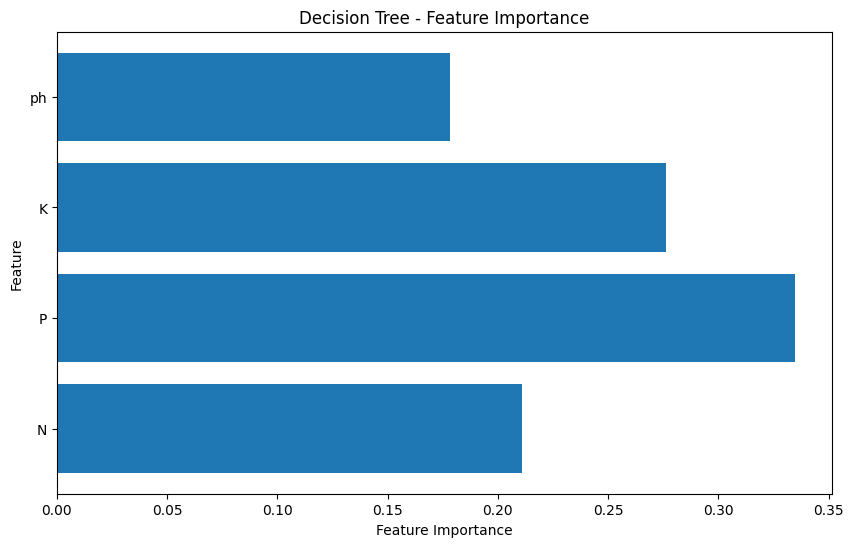

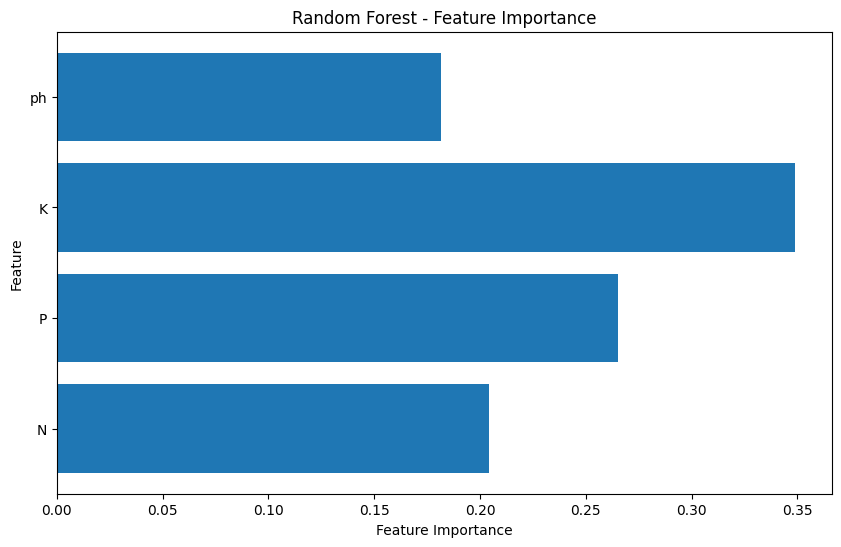

Feature Performance using feature_importances_:
Decision Tree: Most Important Feature - P, Importance - 0.3347
Random Forest: Most Important Feature - K, Importance - 0.3489


In [25]:
def find_best_feature_performance(X_train, X_test, y_train, y_test, best_models):
    # Scale the data and convert to DataFrames if they are not already
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train, columns=X_train.columns)
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=X_test.columns)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    feature_performance = {}

    for model_entry in best_models:
        model_name = model_entry['Model']
        best_params = model_entry['Best Parameters']

        if model_name == 'Random Forest':
            model = RandomForestClassifier(n_estimators=best_params['clf__n_estimators'],
                                           max_depth=best_params['clf__max_depth'],
                                           min_samples_split=best_params['clf__min_samples_split'])
        elif model_name == 'Decision Tree':
            model = DecisionTreeClassifier(criterion=best_params['clf__criterion'],
                                           max_depth=best_params['clf__max_depth'],
                                           min_samples_split=best_params['clf__min_samples_split'])
        else:
            continue 

        model.fit(X_train_scaled, y_train)
        
        # Get feature importances
        feature_importance = model.feature_importances_
        
        # Identify the most important feature
        most_important_feature_index = feature_importance.argmax()
        most_important_feature_name = X_train.columns[most_important_feature_index]
        feature_performance[model_name] = {
            'Feature': most_important_feature_name,
            'Importance': feature_importance[most_important_feature_index]
        }

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feature_importance)), feature_importance, align='center')
        plt.yticks(range(len(feature_importance)), X_train.columns)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title(f'{model_name} - Feature Importance')
        plt.show()

    return feature_performance

feature_performance = find_best_feature_performance(X_train_scaled, X_test_scaled, y_train, y_test, best_models)
print("Feature Performance using feature_importances_:")
for model_name, perf in feature_performance.items():
    print(f"{model_name}: Most Important Feature - {perf['Feature']}, Importance - {perf['Importance']:.4f}")

In [23]:
feature_performance['Logistic Regression'] = {
            'Feature': log_reg_best_feature,
            'Importance': log_reg_best_importance
        }

feature_performance_df = pd.DataFrame(feature_performance)

## Summary of Results

In [24]:
summaries = [
    {'Baseline Performance:': baseline_perf},
    {'Improved Performance:': best_models_df[['Model', 'Best CV Accuracy']]},
    {'Most Important Feature per model:': feature_performance_df}
]

for df in summaries:
    for key, value in df.items():
        print(key)
        print(value)
        print("\n\n")

Baseline Performance:
                 Model  Accuracy
0  Logistic Regression  0.679545
1        Decision Tree  0.754545
2        Random Forest  0.781818



Improved Performance:
                 Model  Best CV Accuracy
0  Logistic Regression          0.682955
1        Decision Tree          0.794886
2        Random Forest          0.806818



Most Important Feature per model:
           Decision Tree Random Forest Logistic Regression
Feature                P             K                   K
Importance      0.339425      0.346242                 1.0



